<a href="https://colab.research.google.com/github/JackBstn/NLP/blob/main/chronos_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chronos Fine-Tuning on financial time series data

This notebook is designed to fine-tune and evaluate the performance of the Chronos forecasting model on financial time series data.
It begins by installing necessary dependencies and downloading historical stock data using Yahoo Finance.
The data is then converted to the Arrow format for efficient processing, as requested by Chronos.

The notebook sets up a configuration for training the Chronos model, including parameters like learning rate and maximum steps.
It trains the model using the specified configuration
and evaluates its performance by comparing the fine-tuned model's predictions
against a zero-shot model (pre-trained without fine-tuning).

The evaluation includes calculating various metrics such as MSE, RMSE, MAPE, and MASE,
and visualizing the forecast results to compare the performance of the fine-tuned model against the zero-shot model.

#### Install Dependencies

In [1]:
!pip install yfinance

# Clone the Chronos repository and install training dependencies
!git clone https://github.com/amazon-science/chronos-forecasting.git
%cd chronos-forecasting
!pip install -e .[training]
%cd ..

# Install Chronos
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

fatal: destination path 'chronos-forecasting' already exists and is not an empty directory.
/content/chronos-forecasting
Obtaining file:///content/chronos-forecasting
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for chronos-forecasting (pyproject.toml) ... done
  Created wheel for chronos-forecasting: filename=chronos_forecasting-1.4.1-py3-none-any.whl size=15021 sha256=7b6366e4ba981e611e75c8a4509bd4ca4c9c7ce7e13a76806df004bafc646775
  Stored in directory: /tmp/pip-ephem-wheel-cache-h3a31g_i/wheels/c6/39/db/dd220df162dd4979e9436a4468e9994a416eaf961c6899d07b
Successfully built chronos-forecasting
  Attempting uninstall: chronos-forecasting
    Found existing installation: chronos-forecasting 1.4.1
    Uninstalling chronos-forecasting-1.4.1:
      Successfully unins

In [2]:
import torch
import numpy as np
import pandas as pd
import yfinance as yf
from pathlib import Path
from typing import List, Union
import matplotlib.pyplot as plt
from gluonts.dataset.arrow import ArrowWriter
from chronos import BaseChronosPipeline, ChronosPipeline

def reset_seed():
  """ Reset seed for reproducibility """
  seed = 343126
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)

In [3]:
tickers = ["AAPL"]
time_series_list = []

for ticker in tickers:
    df = yf.download(ticker, start="2013-01-01", end="2023-01-01")
    time_series_list.append(df["Close"].values.flatten())

[*********************100%***********************]  1 of 1 completed


In [4]:
def convert_to_arrow(path: Union[str, Path], time_series: Union[List[np.ndarray], np.ndarray], compression: str = "lz4"):
    """
    Save a set of time series in Arrow format at the specified path.
    Each time series is flattened to ensure it is saved as a 1D array.
    """

    # Set an arbitrary start time
    start = np.datetime64("2000-01-01 00:00", "s")

    # For each time series, ensure it is a 1D array
    dataset = [{ "start": start, "target": np.array(ts).flatten() } for ts in time_series]

    ArrowWriter(compression=compression).write_to_file(dataset, path=path)
    print(f"File Arrow saved in: {path}")

In [5]:
# Save the data to /content/stock_data.arrow
convert_to_arrow("/content/stock_data.arrow", time_series=time_series_list)

File Arrow saved in: /content/stock_data.arrow


## Fine-Tuning Chronos

#### Fine-Tuning Configuration

In [6]:
%%writefile /content/config.yaml
training_data_paths:
- "/content/stock_data.arrow"
probability:
- 1.0

model_id: "amazon/chronos-t5-tiny"
random_init: false

max_steps: 10000
learning_rate: 0.001

shuffle_buffer_length: 1000
torch_compile: false

Overwriting /content/config.yaml


#### Chronos Fine-Tuning

In [7]:
reset_seed() # For reproducibility

# Fine-tune
!CUDA_VISIBLE_DEVICES=0 python chronos-forecasting/scripts/training/train.py --config /content/config.yaml

# Move result and zip folder
!mv "output/run-0/checkpoint-final" "finetuned_model"
!rm -r output
!zip -r finetuned_model.zip finetuned_model

2025-02-06 10:51:39.301593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738839099.335694   11207 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738839099.345912   11207 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 10:51:48,307 - /content/chronos-forecasting/scripts/training/train.py - INFO - TF32 format is only available on devices with compute capability >= 8. Setting tf32 to False.
2025-02-06 10:51:48,307 - /content/chronos-forecasting/scripts/training/train.py - INFO - Using SEED: 238316161
2025-02-06 10:51:48,311 - /content/chronos-forecasting/scripts/training/train.py - INFO - Logging dir: output/run-0
2025-02-06 10:51:48,314 -

### Comparison between Zero-Shot and Fine-Tuned Models

In [8]:
from scipy.stats import gmean
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_forecast_stats(forecast_tensor):
    """ Compute mean, confidence interval, and variance for the forecast """
    low, median, high = np.quantile(forecast_tensor.numpy(), [0.1, 0.5, 0.9], axis=0)
    mean_forecast = np.mean(forecast_tensor.numpy(), axis=0)
    variance_forecast = np.var(forecast_tensor.numpy(), axis=0)
    return low, median, high, mean_forecast, variance_forecast


# Evaluation metrics
def mase(y_true, y_pred, y_train):
    """
    Compute the Mean Absolute Scaled Error (MASE)
    y_true: true values
    y_pred: predicted values
    y_train: historical series to calculate the naive benchmark
    """
    naive_forecast = np.abs(np.diff(y_train)).mean()  # Naive Model: mean differences between successive values
    return np.mean(np.abs(y_true - y_pred)) / naive_forecast


def compute_metrics(y_true, y_pred, y_train):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mase_score = mase(y_true, y_pred, y_train)
    return { "MSE": mse, "RMSE": rmse, "MAPE": mape, "MASE": mase_score }


def agg_relative_score(model_df: pd.DataFrame, baseline_df: pd.DataFrame):
    relative_score = model_df / baseline_df  # Ratio between model and baseline
    return relative_score.agg(gmean)  # Geometric mean of improvements

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Archive:  finetuned_model_1000.zip
  inflating: finetuned_model/config.json  
  inflating: finetuned_model/generation_config.json  
  inflating: finetuned_model/model.safetensors  
   creating: finetuned_model/checkpoint-final/
  inflating: finetuned_model/checkpoint-final/config.json  
  inflating: finetuned_model/checkpoint-final/generation_config.json  
  inflating: finetuned_model/checkpoint-final/model.safetensors  
  inflating: finetuned_model/checkpoint-final/training_info.json  
  inflating: finetuned_model/training_info.json  
----------- AAPL -----------
Variance (Zero-Shot): [ 4.3272142  7.092312   9.9606495 22.242016  34.456013  62.82077
 58.426216  52.896034  45.29648   51.401283 ]
Variance (Fine-Tuned): [ 3.3172252  8.488328  12.977107  19.476864  24.396624  21.977161
 27.556732  30.070454  34.16423   30.972713 ]


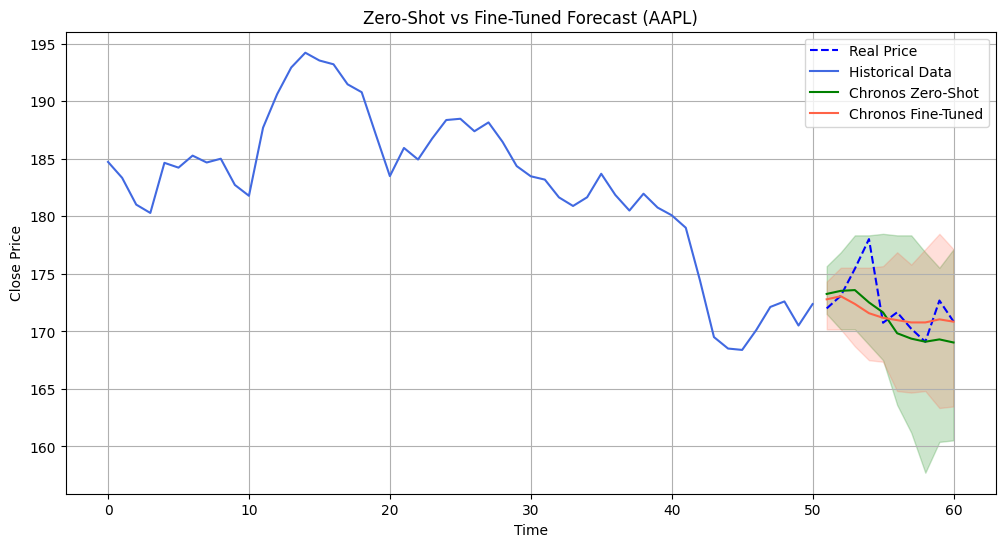

<ipython-input-8-da3d5f9a98b5>:34: FutureWarning: using <function gmean at 0x7f6d3dc544a0> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  return relative_score.agg(gmean)  # Geometric mean of improvements



PERFORMANCE METRICS:
                          MSE      RMSE      MAPE      MASE
Chronos Zero-Shot    8.527447  2.920179  1.340239  1.459950
Chronos Fine-Tuned  18.792763  4.335062  2.244439  2.437162
SCALING PERFORMANCE (Fine-Tuned vs Zero-Shot):
MSE     2.203797
RMSE    1.484519
MAPE    1.674656
MASE    1.669347
dtype: float64
----------- GOOGL -----------
Variance (Zero-Shot): [ 5.429182  10.3904705 12.291628  23.394697  24.618221  31.580173
 78.93699   63.08239   53.66263   61.374817 ]
Variance (Fine-Tuned): [ 7.0426054  8.938386  17.691252  19.081493  20.823978  20.057611
 17.898293  16.594097  27.307276  40.830513 ]


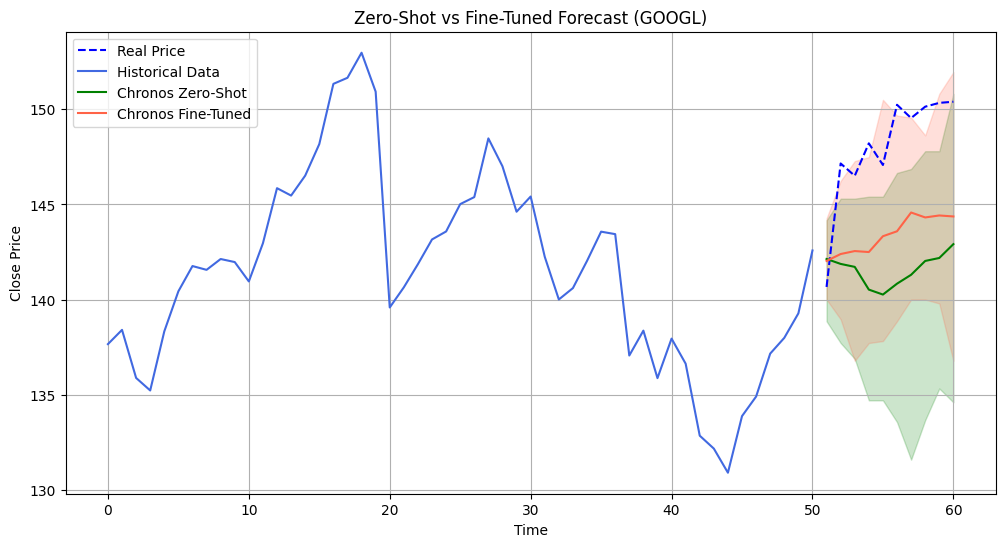


PERFORMANCE METRICS:
                          MSE      RMSE      MAPE      MASE
Chronos Zero-Shot   52.883507  7.272105  4.837250  3.536829
Chronos Fine-Tuned  54.572226  7.387302  4.874984  3.565099
SCALING PERFORMANCE (Fine-Tuned vs Zero-Shot):
MSE     1.031933
RMSE    1.015841
MAPE    1.007801
MASE    1.007993
dtype: float64


<ipython-input-8-da3d5f9a98b5>:34: FutureWarning: using <function gmean at 0x7f6d3dc544a0> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  return relative_score.agg(gmean)  # Geometric mean of improvements


In [9]:
reset_seed() # For reproducibility

# Chronos model (Zero-Shot)
zero_shot_pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-t5-tiny", device_map="cuda", torch_dtype=torch.bfloat16)

# Fine-tuned Chronos model
!unzip -o finetuned_model_1000.zip # If you're using a fine-tuned model
fine_tuned_pipeline = ChronosPipeline.from_pretrained("finetuned_model")

prediction_length = 10  # Forecasting horizon
symbols = ["AAPL", "GOOGL"]

for symbol in symbols:
    print(f"----------- {symbol} -----------")

    # Download financial data from Yahoo Finance
    data = yf.download(symbol, start="2024-01-01", end="2024-03-31", progress=False)

    # Extract the closing prices
    df = data.reset_index()
    close_prices = df["Close"].values.reshape(-1)

    close_prices_to_predict = close_prices[-prediction_length:] # Last prediction_length values
    close_prices = close_prices[:-prediction_length] # Everything except the last prediction_length values

    # Zero-Shot
    forecast_zero_shot = zero_shot_pipeline.predict(context=torch.tensor(close_prices), prediction_length=prediction_length)

    # Fine-Tuned
    forecast_fine_tuned = fine_tuned_pipeline.predict(context=torch.tensor(close_prices), prediction_length=prediction_length)

    # Compute statistics for both models
    low_zero, median_zero, high_zero, mean_zero, var_zero = get_forecast_stats(forecast_zero_shot[0])
    low_fine, median_fine, high_fine, mean_fine, var_fine = get_forecast_stats(forecast_fine_tuned[0])

    print(f'Variance (Zero-Shot): {var_zero}')
    print(f'Variance (Fine-Tuned): {var_fine}')

    # Plot the forecast comparison
    forecast_index = range(len(close_prices), len(close_prices) + prediction_length)
    plt.figure(figsize=(12, 6))

    plt.plot(forecast_index, close_prices_to_predict, color="blue", linestyle="--", label="Real Price")
    plt.plot(close_prices, color="royalblue", label="Historical Data")
    plt.plot(forecast_index, mean_zero, color="green", label="Chronos Zero-Shot")
    plt.fill_between(forecast_index, low_zero, high_zero, color="green", alpha=0.2)
    plt.plot(forecast_index, mean_fine, color="tomato", label="Chronos Fine-Tuned")
    plt.fill_between(forecast_index, low_fine, high_fine, color="tomato", alpha=0.2)
    plt.title(f"Zero-Shot vs Fine-Tuned Forecast ({symbol})")
    plt.xlabel("Time")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid()
    plt.show()
    plt.close()

    # ----- Comparison of performance metrics -----

    # Zero-Shot (use mean of the predicted distribution)
    forecast_zero_shot = zero_shot_pipeline.predict(context=torch.tensor(close_prices), prediction_length=prediction_length)[0].numpy().mean(axis=0)

    # Fine-Tuned (use mean of the predicted distribution)
    forecast_fine_tuned = fine_tuned_pipeline.predict(context=torch.tensor(close_prices), prediction_length=prediction_length)[0].numpy().mean(axis=0)

    # Use real values for comparison
    actual_values = close_prices[-prediction_length:]

    # Numerical results for both models
    metrics_zero_shot = compute_metrics(actual_values, forecast_zero_shot, close_prices[:-prediction_length])
    metrics_fine_tuned = compute_metrics(actual_values, forecast_fine_tuned, close_prices[:-prediction_length])

    # Create a DataFrame for comparison
    results_df = pd.DataFrame([metrics_zero_shot, metrics_fine_tuned], index=["Chronos Zero-Shot", "Chronos Fine-Tuned"])

    # Comparison between Fine-Tuned and Zero-Shot models
    relative_scores = agg_relative_score(results_df.loc["Chronos Fine-Tuned"], results_df.loc["Chronos Zero-Shot"])

    # Output the results
    print("\nPERFORMANCE METRICS:")
    print(results_df)
    print("SCALING PERFORMANCE (Fine-Tuned vs Zero-Shot):")
    print(relative_scores)